In [1699]:
import os
import pickle
from itertools import combinations
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import sys
sys.path.append("..")
import multidms
from timeit import default_timer as timer
import importlib

### Globals

In [1700]:
exp_name = None #"clip_search"
substitution_column = 'aa_substitutions_reference'
experiment_column = 'homolog_exp'

In [1701]:
fit_params = {
    "fs_scaling_group_column" : "homolog_exp",
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "agg_variants" : True,
    "sample" : False, # 10000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "scale_counts" : False,
    "conditions" : ["Delta-3-1", "Omicron_BA.1-3-1"],
    "shift_func_score_target_nonref" : False, 
    "include_stop_variants" : True,
    "warmup_to_ref" : False,
    "maxiter" : 10000,
    "λ_lasso" : 1e-5,
    "λ_ridge" : 0,
    "model" : "non-linear",
    "lower_bound" : -3.5,
    "hinge_scale" : 0.1
}
reference_condition = fit_params['conditions'][0] # always use the first condition as the reference.
cols = list(fit_params.keys()) + [
    "tuned_model_params", "mutation_effects_df", "variant_prediction_df", "site_map"
]

In [1702]:
# uncomment if you want to reset all results
# results = pd.DataFrame(columns = cols)

In [1703]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)

In [1704]:
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


In [1706]:
func_score_data = func_score_data.query(
    f"{experiment_column}.isin({fit_params['conditions']})"
)

func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
11,2022-06-22_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1,Lib-3_2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-3_2022-06-22_thaw-...,library pre_samp...,125127,Omicron_BA.1,Omicron_BA.1-3-1


In [1707]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])

  0%|          | 0/2 [00:00<?, ?it/s]

In [1708]:
if fit_params["sample"]:
    func_score_df = func_score_df.sample(fit_params["sample"])

In [1709]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_column]:
        gapped_sub_vars.append(idx)
    for sub in row[substitution_column].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/162830 [00:00<?, ?it/s]

In [1710]:
# TODO re-write and make function
# def normalize_by_freq()?
if fit_params['scale_counts']:
    dfs = []
    for (h, hdf) in func_score_df.groupby(fit_params["fs_scaling_group_column"]):
        n_post_counts = sum(hdf['post_count'])
        if 'Delta' in h:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        else:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        hdf['orig_post_count'] = hdf['post_count']
        hdf['post_count'] *= scaling_factor
        hdf['post_count_wt'] *= scaling_factor
        print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

        # Recompute enrichment ratios with new counts
        hdf['pre_count_ps'] = hdf['pre_count'] + fit_params["pseudocount"]
        hdf['post_count_ps'] = hdf['post_count'] + fit_params["pseudocount"]
        hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + fit_params["pseudocount"]
        hdf['post_count_wt_ps'] = hdf['post_count_wt'] + fit_params["pseudocount"]

        total_pre_count = sum(hdf['pre_count_ps'])
        total_post_count = sum(hdf['post_count_ps'])

        hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
        hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
        hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
        hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

        hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
        hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
        hdf['e'] = hdf['var_e'] / hdf['wt_e']
        #hdf.dropna(subset=['e'], inplace=True)
        hdf['func_score'] = hdf['e'].apply(lambda x: math.log(x, 2))
        dfs.append(hdf)
    func_score_df = pd.concat(dfs)

In [1711]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= fit_params["min_pre_counts"]]
#     print(f'Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {min_pre_counts} counts before selection, and were filtered out')

In [1712]:
# results["include_stop_variants"] = True
if not fit_params["include_stop_variants"]:
    stop_variants = [idx for idx, row in func_score_df.iterrows() if "*" in row[substitution_column]]
    func_score_df = func_score_df.drop(stop_variants)

In [1713]:
if fit_params["agg_variants"]:
    func_score_df = func_score_df.groupby([substitution_column, experiment_column]).mean().reset_index()
func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
func_score_df["post_count"] = func_score_df["post_count"].astype(int)

In [1714]:
# TODO, what's the order of operations?
if fit_params["shift_func_score_target_nonref"]:
    h2_idx = func_score_df.query(f"{experiment_column} == '{fit_params['experiment_2']}'").index
    func_score_df.loc[h2_idx, fit_params["func_score_target"]] += fit_params["shift_func_score_target_nonref"]

In [1715]:
if fit_params['clip_target']:
    func_score_df["func_score"] = func_score_df["func_score"].clip(*fit_params["clip_target"])

In [1716]:
importlib.reload(multidms.utils)

<module 'multidms.utils' from '/home/jgallowa/Projects/multidms/notebooks/../multidms/utils.py'>

In [1717]:
# multidms = importlib.reload(multidms)
(X, y), df, all_subs, site_map = multidms.utils.create_homolog_modeling_data(
                            func_score_df, 
                            experiment_column,
                            reference_condition, # the first condition is always the reference
                            substitution_column,
                            "func_score"
                        )

sig_upper = df["func_score"].quantile(0.95)
sig_lower = df["func_score"].quantile(0.05)
sig_range = sig_upper - sig_lower

Found 8 site(s) lacking data in at least one homolog.
2723 of the 86572 variants were removed because they had mutations at the above sites, leaving 83849 variants.


100%|█████████████████████████████████████████████████████████████| 58556/58556 [01:55<00:00, 504.83it/s]


There were 0 cache hits in total for homolog Omicron_BA.1-3-1.


In [1718]:
# fit_params["lower_bound"]
fit_params["lower_bound"] = -3.5

In [1719]:
# Initialize all params

params = multidms.utils.initialize_model_params(
    func_score_df[experiment_column].unique(), 
    n_beta_shift_params=X[reference_condition].shape[1],
    include_alpha=True if fit_params["model"] == "non-linear" else False,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [1720]:
params

{'β': DeviceArray([-0.57334713, -0.20234694, -0.40719932, ..., -0.68163857,
               0.71620482,  0.99943656], dtype=float64),
 'S_Delta-3-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Delta-3-1': DeviceArray([0.], dtype=float64),
 'γ_Delta-3-1': DeviceArray([0.], dtype=float64),
 'S_Omicron_BA.1-3-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Omicron_BA.1-3-1': DeviceArray([0.], dtype=float64),
 'γ_Omicron_BA.1-3-1': DeviceArray([0.], dtype=float64),
 'α': {'ge_scale': DeviceArray([4.23316], dtype=float64),
  'ge_bias': DeviceArray([-3.5], dtype=float64)},
 'C_ref': DeviceArray([5.], dtype=float64)}

In [1721]:
importlib.reload(multidms.model)
cost_func = multidms.model.cost_smooth
prox_func = multidms.model.prox
pred_func = multidms.model.f
if fit_params["model"] == "linear":
    cost_func = multidms.model.cost_smooth_linear
    prox_func = multidms.model.prox_linear
    pred_func = multidms.model.f_linear

In [1722]:
print(f"\nPre-Optimization")
print(f"----------------")
pred = cost_func(
    params, 
    (X, y), 
    λ_ridge=fit_params['λ_ridge'], 
    lower_bound=fit_params['lower_bound'], 
    hinge_scale=fit_params['hinge_scale']
)
print(f"cost = {pred:.2e}")

tol = 1e-6
maxiter = fit_params['maxiter']
start = timer()

solver = ProximalGradient(cost_func, prox_func, tol=tol, maxiter=maxiter)

lock_params = {
    f"S_{reference_condition}" : jnp.zeros(len(params['β'])),
    f"γ_{reference_condition}" : jnp.zeros(shape=(1,)),
}
for condition in fit_params['conditions']:
    lock_params[f"C_{condition}"] = jnp.zeros(shape=(1,))

lasso_params = {}
for non_ref_condition in fit_params['conditions'][1:]:
    lasso_params[f"S_{non_ref_condition}"] = fit_params['λ_lasso']

print('Fitting model')
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        lasso_params = lasso_params,
        lock_params = lock_params
    ),
    data=(X, y),
    λ_ridge=fit_params['λ_ridge'],
    lower_bound=fit_params['lower_bound'],
    hinge_scale=fit_params['hinge_scale']
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
pred = cost_func(
    params, 
    (X, y), 
    λ_ridge=fit_params['λ_ridge'], 
    lower_bound=fit_params['lower_bound'], 
    hinge_scale=fit_params['hinge_scale']
)
print(f"cost = {pred:.2e}")
print(f"Wall time for fit: {end - start}")
print(f"\nDONE :)")
print(f"-------------------")


Pre-Optimization
----------------
cost = 3.39e+00
Fitting model

Post-Optimization
-----------------
Full model optimization: 10000 iterations
error = 1.93e-03
cost = 4.71e-01
Wall time for fit: 108.59641273040324

DONE :)
-------------------


In [1723]:
df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_func_score"] = onp.nan
df[f"corrected_func_score"] = df[f"func_score"]

print(f"\nRunning Predictions")
print(f"-------------------")

# sub string, wt, site, mut, Beta, {S_c}, {F_c}
# TODO number of times seen?

mut_effect_df = pd.DataFrame({
    "substitution" : all_subs,
    "β" : params["β"]
})

mut_effect_df["wt"], mut_effect_df["site"], mut_effect_df["mut"] = zip(
  *mut_effect_df["substitution"].map(multidms.utils.split_sub)
)

binary_single_subs = sparse.BCOO.fromdense(onp.identity(len(all_subs)))

for homolog, hdf in df.groupby(experiment_column):
    
    # collect relevant params
    h_params = {
        "β":params["β"], 
        "C_ref":params["C_ref"],
        "S":params[f"S_{homolog}"], 
        "C":params[f"C_{homolog}"],
    }
    
    if fit_params["model"] == "non-linear": h_params["α"] = params["α"]
    
    # latent predictions on all variants
    z_h = multidms.model.ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h

    # full model predictions
    y_h_pred = pred_func(
        h_params, 
        X[homolog], 
        lower_bound=fit_params['lower_bound'], 
        hinge_scale=fit_params['hinge_scale']
    )
    df.loc[hdf.index, f"predicted_func_score"] = y_h_pred
    
    # add the corrected functional scores by tuned gamma
    df.loc[hdf.index, f"corrected_func_score"] += params[f"γ_{homolog}"][0]
    
    # attach relevent params to mut effects df
    mut_effect_df[f"S_{homolog}"] = params[f"S_{homolog}"]
    
    # predictions for all single subs
    mut_effect_df[f"F_{homolog}"] = pred_func(
        h_params, 
        binary_single_subs, 
        lower_bound=fit_params['lower_bound'], 
        hinge_scale=fit_params['hinge_scale']
    )

row = fit_params.copy()

row["variant_prediction_df"] = df.drop("index", axis=1)
row["mutation_effects_df"] = mut_effect_df
row["site_map"] = site_map.copy()
row["tuned_model_params"] = params.copy()

# results = pd.Series(row)
results.loc[len(results)] = pd.Series(row)

print(f"\nDONE :)")
print(f"-------------------")


Running Predictions
-------------------

DONE :)
-------------------


In [1724]:
results.loc[:, [
    "agg_variants", 
    "clip_target",
    "hinge_scale",
    "lower_bound",
    "scale_counts", 
    "model", 
    "conditions"
    ]]

,agg_variants,clip_target,hinge_scale,lower_bound,scale_counts,model,conditions
0,True,"(-3.5, 2.5)",0.1,-3.5,True,non-linear,[Delta-3-1]
1,True,"(-3.5, 2.5)",0.1,-3.5,True,non-linear,[Omicron_BA.1-3-1]
2,True,"(-3.5, 2.5)",0.1,-3.5,True,non-linear,"[Delta-3-1, Omicron_BA.1-3-1]"
3,True,"(-3.5, 2.5)",0.1,-3.5,True,non-linear,"[Delta-2-1, Omicron_BA.1-2-1]"
4,True,"(-3.5, 2.5)",0.1,-3.5,True,non-linear,"[Delta-2-1, Omicron_BA.1-2-1, Delta-3-1, Omicr..."
5,True,"(-3.5, 2.5)",0.1,-3.5,False,non-linear,"[Delta-3-1, Omicron_BA.1-3-1]"
6,True,"(-3.5, 2.5)",0.1,-3.5,False,non-linear,"[Delta-3-1, Omicron_BA.1-3-1]"


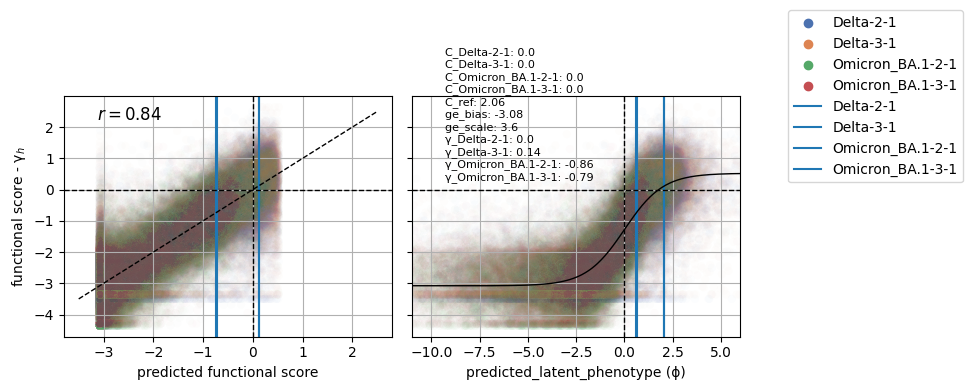

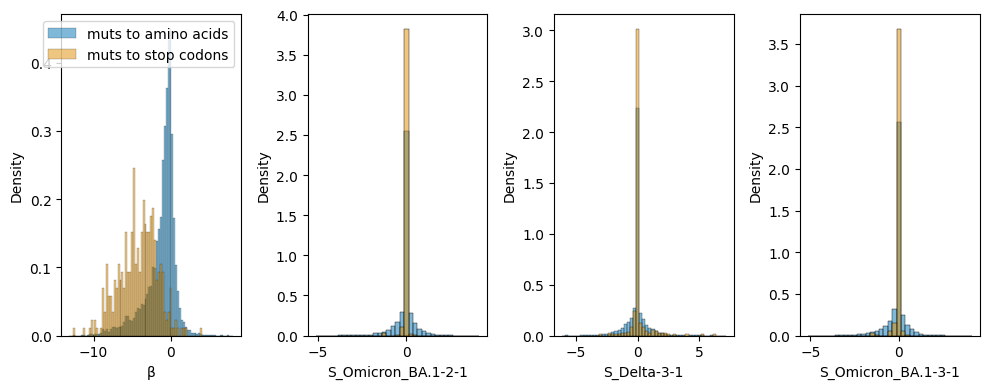

In [ ]:
importlib.reload(multidms.plot)
exps = [4]
res = results.loc[exps, :]
# res = results.loc[len(results)-1:len(results), :]

multidms.plot.plot_pred_scatter(
    res, 
    #annotation_vars=list(fit_params.keys()), 
    hue=True, 
    printrow=False,
    annotate_params=True,
)
multidms.plot.plot_param_hist(
    res,
    printrow=False
)
multidms.plot.plot_param_heatmap(
    res, 
    printrow=False
)
multidms.plot.plot_param_by_site(
    res, 
    printrow=False
)
# multidms.plot.plot_fit_param_comp_scatter(
#     res, 
#     {0:"β", 1:"β"}
# )
# multidms.plot.plot_fit_param_comp_scatter(
#     res, 
#     {2:"S_Omicron_BA.1-2-1", 3:"S_Omicron_BA.1-3-1"}
# )